In [1]:
%matplotlib notebook
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
num_digits = 2
chars = '0123456789abcdef+ '

char2idx = {c: i for i, c in enumerate(chars)}
idx2char = {i: c for i, c in enumerate(chars)}

maxlen = num_digits * 2 + 1

def make_dataset(num_examples):
    X = np.zeros((num_examples, maxlen, len(chars)))
    y = np.zeros((num_examples, num_digits + 1, len(chars)))
    
    n1 = np.random.randint(0, 16**(num_digits)-1, num_examples)
    n2 = np.random.randint(0, 16**(num_digits)-1, num_examples)    
    res = n1 + n2
    for i in range(num_examples):
        inp = '%x+%x' % (n1[i], n2[i])
        inp += (maxlen - len(inp)) * ' '   # padding
        out = '%x' % res[i]
        out += (num_digits + 1 - len(out)) * ' '   # padding
        # 1-hot encoding
        for j, c in enumerate(inp[::-1]):  # invert input
            X[i, j, char2idx[c]] = 1
            
        for j, c in enumerate(out):
            y[i, j, char2idx[c]] = 1
            
    return X, y

In [3]:
make_dataset(1)[0]

array([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.]]])

 - input 128,5,18
 - lstm_size  - number of hidden  units

In [4]:
tf.reset_default_graph()
batch_size = 128
lstm_size = 64

input_numbers = tf.placeholder(tf.float32, shape=[batch_size, maxlen, len(chars)])
input_labels = tf.placeholder(tf.int32, shape=[batch_size, num_digits + 1, len(chars)])

inp = tf.unstack(input_numbers, maxlen, 1)

# Encoder
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
#lstm = tf.contrib.rnn.MultiRNNCell([lstm] * 2)
net, states = tf.contrib.rnn.static_rnn(lstm, inp, dtype=tf.float32)

# Decoder.
with tf.variable_scope('foo'):
    lstm2 = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    net2, states = tf.contrib.rnn.static_rnn(lstm2, [net[-1]] * (num_digits + 1), dtype=tf.float32)

logits = tf.contrib.layers.fully_connected(
    tf.stack(net2[-(num_digits+1):], axis=1),
    len(chars), activation_fn=None)

loss = tf.losses.softmax_cross_entropy(input_labels, logits)

In [9]:
## run session first!
x, y = make_dataset(batch_size)
n_  = sess.run(net2, feed_dict={
        input_numbers: x,
        input_labels: y})

type(n_),len(n_),n_[1].shape


(list, 3, (128, 64))

In [10]:
opt = tf.train.AdamOptimizer(learning_rate=0.005)
#opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train_op = opt.minimize(loss)

In [11]:
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)
sess.run(init_op)

#coord = tf.train.Coordinator()
#threads = tf.train.start_queue_runners(sess=sess, coord=coord)

<IPython.core.display.Javascript object>


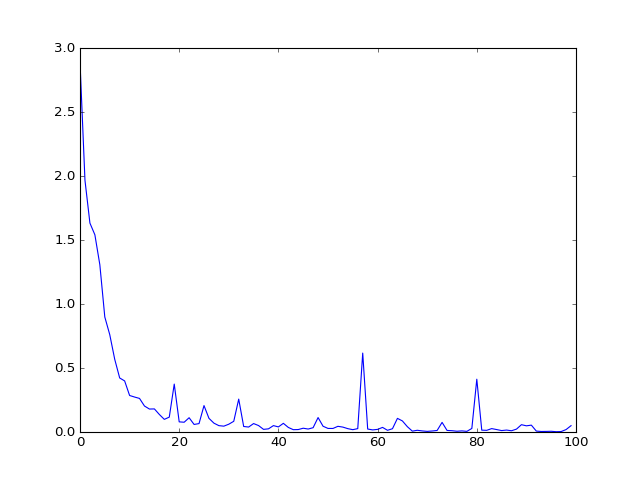

In [12]:
lvals = []
fig,ax = plt.subplots(1,1)

for i in range(10000):
    x, y = make_dataset(batch_size)
    
    l, _ = sess.run([loss, train_op], feed_dict={
        input_numbers: x,
        input_labels: y
    })
    if i % 100 == 0:
        lvals.append(l)
        ax.clear()
        ax.plot(lvals)
        fig.canvas.draw()


In [13]:
x, y = make_dataset(batch_size)
    
l, = sess.run([tf.nn.softmax(logits)], feed_dict={
  input_numbers: x,
  input_labels: y
})


In [14]:
ans = ''
for i in x[0, ...]:
    ans += idx2char[int(np.where(i)[0])]
print(ans)

f3+3b


In [15]:
ans = ''
for i in y[0, ...]:
    ans += idx2char[int(np.where(i)[0])]
print(ans)

f2 


In [16]:
ans = ''
for i in np.argmax(l[0, ...], axis=1):
    ans += idx2char[i]
print(ans)

f2 


In [17]:
y[12],l[12]

(array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  1.]]),
 array([[  1.26185921e-06,   1.09198455e-08,   2.67718570e-10,
           1.13584803e-12,   1.39543900e-16,   1.37174915e-20,
           3.08802738e-15,   1.27898679e-12,   2.36563380e-10,
           3.11430354e-10,   1.14814758e-09,   7.27809535e-10,
           5.96753651e-08,   2.85988022e-02,   9.71249938e-01,
           1.49891101e-04,   3.04809486e-15,   1.14950405e-09],
        [  9.99201953e-01,   3.49292786e-05,   1.10087490e-06,
           5.97070979e-08,   3.79177679e-12,   1.08472742e-14,
           4.43760798e-14,   4.71713906e-17,   1.55628263e-18,
           4.54876863e-16,   2.29713549e-17,   1.28046309e-15,
           6.52038090e-10,   1.01841324e

In [18]:
np.argmax(l[0,:],axis=1)

array([15,  2, 17])

In [19]:
np.argmax(y[0,:],axis=1)

array([15,  2, 17])

In [20]:
for _ in range(10):
    x, y = make_dataset(batch_size)
    
    l, = sess.run([tf.nn.softmax(logits)], feed_dict={
      input_numbers: x,
      input_labels: y
    })

    r = np.sum(np.all( np.argmax(y,axis=-1) == np.argmax(l,axis=-1),axis=-1 ))/batch_size
    print(r)

0.96875
0.9765625
0.9765625
0.9609375
0.984375
0.953125
0.953125
0.9609375
0.9375
0.953125
